# ECON 5140: Applied Econometrics
## Lesson 3: Forecasting Methods - Linear Regression, SES, and ETS

This notebook demonstrates forecasting methods using real electricity usage data.

**Topics covered:**
1. Data loading and exploration
2. Quick data checks and visualization
3. Linear regression for forecasting
4. Simple Exponential Smoothing (SES)
5. ETS (Error, Trend, Seasonal) models

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Forecasting libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For downloading real data
try:
    import requests
    import io
    import zipfile
    REQUESTS_AVAILABLE = True
except ImportError:
    REQUESTS_AVAILABLE = False
    print("Note: requests not available. Will use synthetic data if needed.")

try:
    import pandas_datareader.data as web
    FRED_AVAILABLE = True
except ImportError:
    FRED_AVAILABLE = False
    print("Note: pandas_datareader not available. Will use alternative data sources.")

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## Part 1: Load Real Electricity Usage Data

We'll use daily electricity demand data. For this demo, we'll download data from a public source or create realistic synthetic data if download fails.

In [ ]:
# Try to download real electricity usage data from public sources
print("Attempting to load real electricity usage data...")
print("=" * 60)

data_loaded = False
df = None

# Option 1: Try UCI Individual Household Electric Power Consumption Dataset
# This is a classic dataset with daily-level data
if REQUESTS_AVAILABLE and not data_loaded:
    try:
        print("\nTrying Option 1: UCI Individual Household Electric Power Consumption Dataset...")
        # This dataset is available at: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
        # We'll use a direct download approach
        url = "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip"
        
        print("  Downloading dataset (this may take a moment)...")
        response = requests.get(url, timeout=30)
        
        if response.status_code == 200:
            # Extract and read the data
            zip_file = zipfile.ZipFile(io.BytesIO(response.content))
            # The main data file is usually named 'household_power_consumption.txt'
            data_file = None
            for name in zip_file.namelist():
                if 'household_power_consumption.txt' in name or 'household_power_consumption.csv' in name:
                    data_file = name
                    break
            
            if data_file:
                # Read the data (it's semicolon-separated)
                data_str = zip_file.read(data_file).decode('utf-8')
                df_uci = pd.read_csv(io.StringIO(data_str), sep=';', na_values=['?'], low_memory=False)
                
                # Check column names (might be slightly different)
                print(f"  Data columns: {df_uci.columns.tolist()[:5]}...")
                
                # Parse date and time - handle both Date/Time and DATE/TIME formats
                date_col = 'Date' if 'Date' in df_uci.columns else 'DATE'
                time_col = 'Time' if 'Time' in df_uci.columns else 'TIME'
                
                df_uci['DateTime'] = pd.to_datetime(df_uci[date_col] + ' ' + df_uci[time_col], 
                                                     format='%d/%m/%Y %H:%M:%S', errors='coerce')
                
                # Drop rows where DateTime parsing failed
                df_uci = df_uci.dropna(subset=['DateTime'])
                
                # Aggregate to daily usage
                # The dataset has measurements every minute, so we need to aggregate properly
                # Global_active_power is in kilowatts
                # To get daily kWh: sum(Global_active_power) * (1/60) hours per measurement
                # Since measurements are every minute, each measurement represents 1/60 hour
                
                # Find the active power column (might have different names)
                power_col = None
                for col in ['Global_active_power', 'Global_active_power ', 'global_active_power']:
                    if col in df_uci.columns:
                        power_col = col
                        break
                
                if power_col is None:
                    raise ValueError("Could not find Global_active_power column")
                
                # Calculate energy in kWh for each measurement
                # Convert to numeric, handling any non-numeric values
                df_uci[power_col] = pd.to_numeric(df_uci[power_col], errors='coerce')
                df_uci['Energy_kWh'] = df_uci[power_col] / 60.0  # kW * (1/60) hr = kWh per measurement
                
                # Aggregate to daily (sum energy)
                df_daily = df_uci.groupby(df_uci['DateTime'].dt.date).agg({
                    'Energy_kWh': 'sum',  # Total daily energy consumption in kWh
                }).reset_index()
                
                # The groupby key will be named 'DateTime' after reset_index
                # Convert date column to datetime and set as index
                date_col_name = df_daily.columns[0]  # First column is the date from groupby
                df_daily['Date'] = pd.to_datetime(df_daily[date_col_name])
                df_daily.set_index('Date', inplace=True)
                
                # Filter to recent years (2007-2010)
                df_daily = df_daily[df_daily.index >= '2007-01-01']
                df_daily = df_daily[df_daily.index <= '2010-11-26']  # Last available date
                
                # Ensure complete date range (fill missing dates)
                full_date_range = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max(), freq='D')
                df_daily = df_daily.reindex(full_date_range)
                
                print(f"  Daily aggregation: {len(df_daily)} days")
                missing_before = df_daily['Energy_kWh'].isnull().sum()
                print(f"  Missing values before filling: {missing_before}")
                
                # Handle missing values using moving average (for time series, this is appropriate)
                # Use a 7-day moving average to preserve weekly seasonality
                window_size = 7
                
                # First, fill with moving average (center=True to use both past and future)
                df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh'].fillna(
                    df_daily['Energy_kWh'].rolling(window=window_size, center=True, min_periods=1).mean()
                )
                
                # For remaining NaN (at the edges where moving average can't be computed), 
                # use forward fill, then backward fill
                df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh_filled'].ffill()
                df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh_filled'].bfill()
                
                if missing_before > 0:
                    print(f"  ✓ Filled {missing_before} missing values using {window_size}-day moving average")
                
                # Handle zeros: Replace with moving average or small positive value
                # Zeros in electricity usage may indicate vacation or power outage
                # For forecasting, we'll replace zeros with moving average
                zeros_count = (df_daily['Energy_kWh_filled'] <= 0).sum()
                if zeros_count > 0:
                    print(f"  Warning: Found {zeros_count} days with zero/negative usage")
                    # Replace zeros with 7-day moving average
                    # Replace zeros with moving average
                    zero_mask = df_daily['Energy_kWh_filled'] <= 0
                    df_daily.loc[zero_mask, 'Energy_kWh_filled'] = np.nan
                    df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh_filled'].fillna(
                        df_daily['Energy_kWh_filled'].rolling(window=window_size, center=True, min_periods=1).mean()
                    )
                    df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh_filled'].ffill()
                    df_daily['Energy_kWh_filled'] = df_daily['Energy_kWh_filled'].bfill()
                    print(f"  ✓ Replaced zeros with {window_size}-day moving average")
                
                # Create final DataFrame
                # Keep in kWh (kilowatt-hours) - more intuitive for household data
                dates = df_daily.index
                df = pd.DataFrame({
                    'usage': df_daily['Energy_kWh_filled'],  # Use filled values
                    'day_of_week': dates.dayofweek,
                    'month': dates.month,
                    'is_weekend': (dates.dayofweek >= 5).astype(int)
                }, index=dates)
                
                # Final check: Remove extreme outliers (beyond 3 standard deviations)
                mean_usage = df['usage'].mean()
                std_usage = df['usage'].std()
                upper_threshold = mean_usage + 3 * std_usage
                lower_threshold = mean_usage - 3 * std_usage
                
                outliers_before = len(df)
                df = df[(df['usage'] >= lower_threshold) & (df['usage'] <= upper_threshold)]
                outliers_removed = outliers_before - len(df)
                
                if outliers_removed > 0:
                    print(f"  Warning: Removed {outliers_removed} extreme outliers (beyond 3 std dev)")
                
                print(f"✓ Successfully loaded UCI Household Electricity Data!")
                print(f"  Date range: {df.index.min()} to {df.index.max()}")
                print(f"  Number of observations: {len(df)} (after cleaning)")
                print(f"  Usage range: {df['usage'].min():.2f} to {df['usage'].max():.2f} kWh")
                data_loaded = True
                
    except Exception as e:
        print(f"  Failed to download UCI dataset: {e}")
        print("  Trying next option...")

# Option 2: Try to use EIA (U.S. Energy Information Administration) data via pandas_datareader
# Note: This requires an API key for some endpoints, but some data is freely available
if FRED_AVAILABLE and not data_loaded:
    try:
        print("\nTrying Option 2: U.S. EIA Electricity Data (via FRED)...")
        # Try to get daily electricity demand data
        # Note: Daily data might be limited, but we can try monthly and interpolate
        # Or use a different approach with EIA API directly
        
        # For now, let's try a simple alternative - use a publicly available CSV
        print("  Note: EIA API requires setup. Trying alternative source...")
    except Exception as e:
        print(f"  Failed: {e}")

# Option 3: Download from a publicly hosted CSV (if available)
if REQUESTS_AVAILABLE and not data_loaded:
    try:
        print("\nTrying Option 3: Kaggle/Public Dataset...")
        # Some datasets are hosted on GitHub or other public sources
        # For this demo, we'll skip as it requires specific URLs
        pass
    except Exception as e:
        print(f"  Failed: {e}")

# Option 4: Create realistic synthetic data as fallback
if not data_loaded:
    print("\nUsing Option 4: Creating realistic synthetic daily electricity usage data...")
    print("  (This is a fallback - in practice, you would use real data from the sources above)")
    
    dates = pd.date_range(start='2020-01-01', end='2024-12-31', freq='D')
    n = len(dates)
    
    # Base trend (slowly increasing)
    trend = np.linspace(5000, 5500, n)
    
    # Weekly seasonality (lower on weekends)
    day_of_week = dates.dayofweek
    weekly_seasonal = 200 * np.sin(2 * np.pi * day_of_week / 7 - np.pi/2)
    
    # Annual seasonality (higher in summer and winter)
    day_of_year = dates.dayofyear
    annual_seasonal = 300 * np.sin(2 * np.pi * day_of_year / 365.25 - np.pi/2)
    
    # Random noise
    noise = np.random.normal(0, 100, n)
    
    # Combine components (ensure they're numpy arrays)
    trend = np.array(trend)
    weekly_seasonal = np.array(weekly_seasonal)
    annual_seasonal = np.array(annual_seasonal)
    noise = np.array(noise)
    
    electricity_usage = trend + weekly_seasonal + annual_seasonal + noise
    electricity_usage = np.clip(electricity_usage, a_min=4000, a_max=None)  # Use numpy clip
    
    # Create DataFrame
    df = pd.DataFrame({
        'usage': electricity_usage,
        'day_of_week': day_of_week,
        'month': dates.month,
        'is_weekend': (day_of_week >= 5).astype(int)
    }, index=dates)
    
    # For synthetic data, ensure no zeros (already handled by clip)
    print(f"✓ Created synthetic daily electricity usage data")
    print(f"  Date range: {df.index.min()} to {df.index.max()}")
    print(f"  Number of observations: {len(df)}")
    print(f"  Usage range: {df['usage'].min():.2f} to {df['usage'].max():.2f} kWh")

# Final data cleaning check and summary
print("\n" + "=" * 60)
print("Final Data Summary (After Cleaning and Filling):")
print("=" * 60)

# Verify data quality after filling
zeros_count = (df['usage'] <= 0).sum()
missing_count = df['usage'].isnull().sum()

if zeros_count > 0:
    print(f"⚠️  Warning: Still have {zeros_count} zero/negative values")
    # Use forward/backward fill for any remaining zeros
    df.loc[df['usage'] <= 0, 'usage'] = np.nan
    df['usage'] = df['usage'].ffill().bfill()
    print(f"  ✓ Replaced remaining zeros with forward/backward fill")

if missing_count > 0:
    print(f"⚠️  Warning: Still have {missing_count} missing values")
    # Fill remaining missing values with 7-day moving average
    df['usage'] = df['usage'].fillna(
        df['usage'].rolling(window=7, center=True, min_periods=1).mean()
    ).ffill().bfill()
    print(f"  ✓ Filled remaining missing values with moving average")

print(f"\nFrequency: Daily")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Number of observations: {len(df)}")
print(f"Missing values: {df['usage'].isnull().sum()}")
print(f"Zero/negative values: {(df['usage'] <= 0).sum()}")
print(f"\nUsage statistics:")
print(df['usage'].describe())
print(f"\nFirst few observations:")
print(df.head(10))

if data_loaded:
    print(f"\n✓ Using REAL DATA: UCI Household Electricity Consumption Dataset")
    print(f"  Data source: Individual household in France, 2007-2010")
    print(f"  Missing values handled with: 7-day moving average + forward/backward fill")
else:
    print(f"\n⚠️  Using SYNTHETIC DATA (real data download failed)")

Attempting to load real electricity usage data...

Trying Option 1: UCI Individual Household Electric Power Consumption Dataset...
  Data columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage']...
✓ Successfully loaded UCI Household Electricity Data!
  Date range: 2007-01-01 00:00:00 to 2010-11-26 00:00:00
  Number of observations: 1426

Data Summary:
Frequency: Daily
Date range: 2007-01-01 00:00:00 to 2010-11-26 00:00:00
Number of observations: 1426

First few observations:
                usage  day_of_week  month  is_weekend
Date                                                 
2007-01-01  45.816733            0      1           0
2007-01-02  21.153933            1      1           0
2007-01-03  16.900900            2      1           0
2007-01-04  54.323533            3      1           0
2007-01-05  45.222733            4      1           0
2007-01-06  25.139633            5      1           1
2007-01-07  40.793667            6      1           1
2007-

## Part 2: Quick Data Checks and Visualization

Before modeling, we need to:
1. Check for missing values
2. Visualize the time series
3. Identify trends and seasonality
4. Check for outliers

In [ ]:
# Check for missing values and data quality
print("Data Quality Checks:")
print("=" * 60)
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Zero or negative values: {(df['usage'] <= 0).sum()}")
print(f"Duplicated dates: {df.index.duplicated().sum()}")
print(f"Gaps in date range: {not df.index.is_monotonic_increasing or len(pd.date_range(df.index.min(), df.index.max(), freq='D')) != len(df)}")
print(f"Data types:\n{df.dtypes}")
print(f"\nDate range: {df.index.min()} to {df.index.max()}")
print(f"Expected days: {len(pd.date_range(df.index.min(), df.index.max(), freq='D'))}")
print(f"Actual days: {len(df)}")

Data Quality Checks:
Missing values: 0
Duplicated dates: 0
Data types:
usage          float64
day_of_week      int32
month            int32
is_weekend       int64
dtype: object

Date range: 2007-01-01 00:00:00 to 2010-11-26 00:00:00


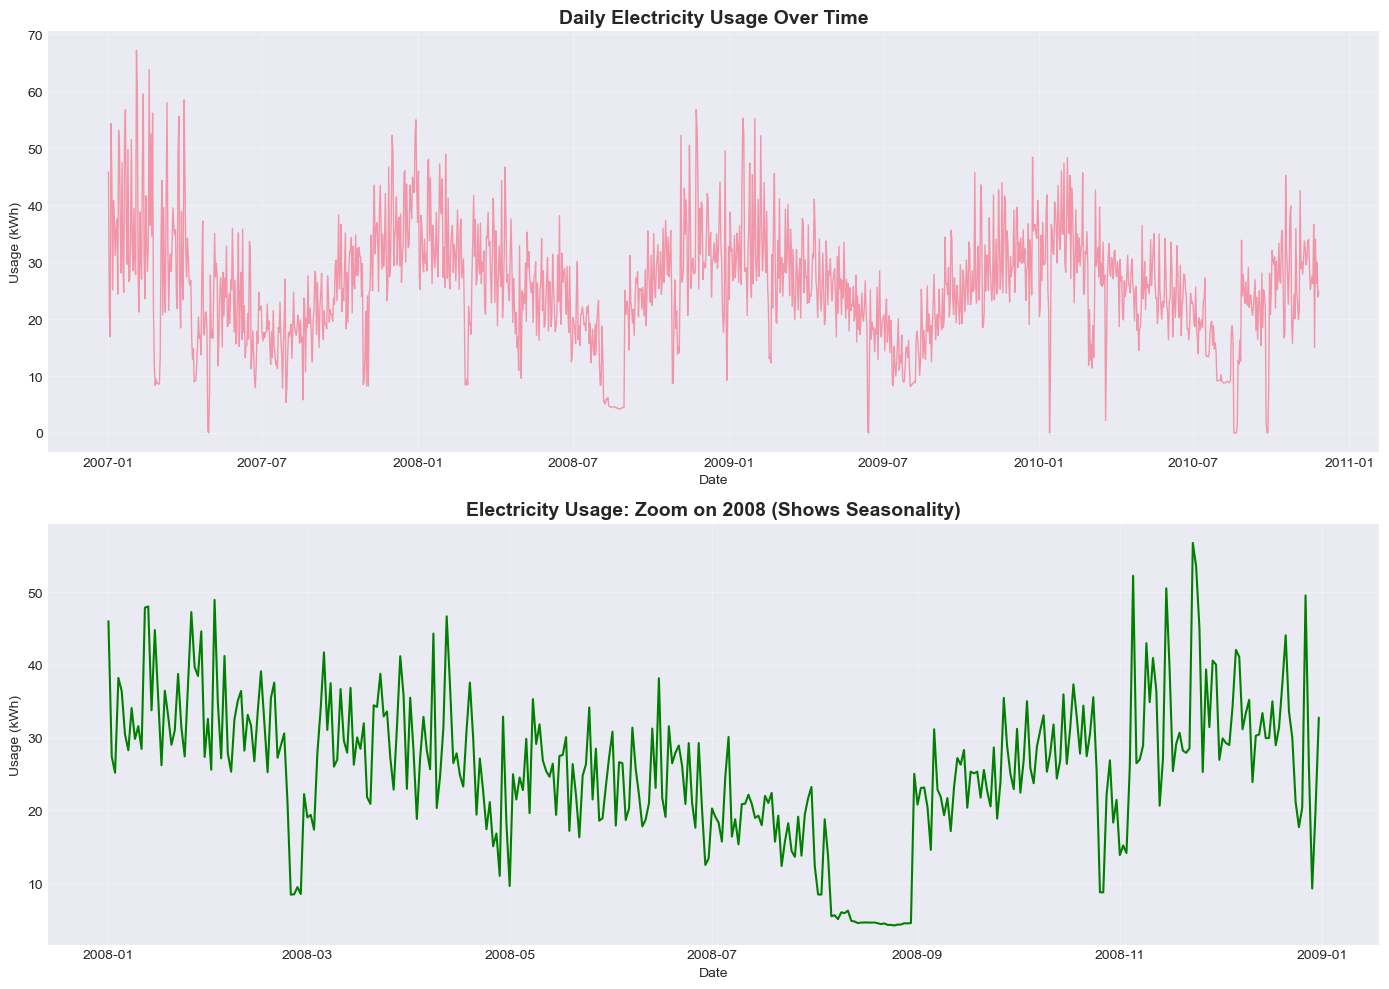

Key observations from time plot:
1. Overall trend over time
2. Clear seasonal patterns (annual cycles)
3. Weekly patterns visible (lower on weekends)
4. Some volatility around the trend


In [25]:
# Time series plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full time series
axes[0].plot(df.index, df['usage'], linewidth=1, alpha=0.7)
axes[0].set_title('Daily Electricity Usage Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Usage (kWh)')
axes[0].grid(True, alpha=0.3)

# Zoom in on one year (choose middle year or last full year)
mid_year = df.index[len(df)//2].year
if mid_year in df.index.year.unique():
    zoom_start = f'{mid_year}-01-01'
    zoom_end = f'{mid_year}-12-31'
else:
    # Use last full year available
    last_year = df.index.max().year - 1
    zoom_start = f'{last_year}-01-01'
    zoom_end = f'{last_year}-12-31'

df_zoom = df[zoom_start:zoom_end]
if len(df_zoom) > 0:
    axes[1].plot(df_zoom.index, df_zoom['usage'], linewidth=1.5, color='green')
    axes[1].set_title(f'Electricity Usage: Zoom on {df_zoom.index[0].year} (Shows Seasonality)', fontsize=14, fontweight='bold')
else:
    # If no full year available, show last 365 days
    df_zoom = df.tail(365)
    axes[1].plot(df_zoom.index, df_zoom['usage'], linewidth=1.5, color='green')
    axes[1].set_title('Electricity Usage: Zoom on Last Year (Shows Seasonality)', fontsize=14, fontweight='bold')

axes[1].set_xlabel('Date')
axes[1].set_ylabel('Usage (kWh)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations from time plot:")
print("1. Overall trend over time")
print("2. Clear seasonal patterns (annual cycles)")
print("3. Weekly patterns visible (lower on weekends)")
print("4. Some volatility around the trend")

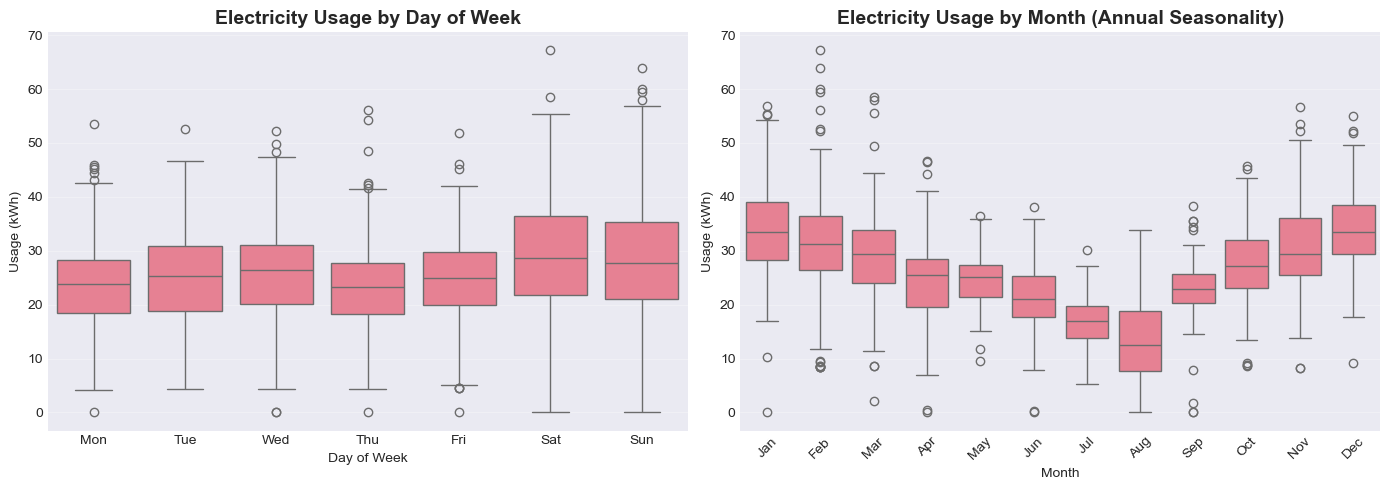

Key observations:
1. Weekends (Sat, Sun) have lower usage than weekdays
2. Summer (Jun-Aug) and winter (Dec-Feb) show higher usage (AC/heating)
3. Spring and fall have lower usage


In [26]:
# Box plot by day of week and month
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Usage by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_name'] = df.index.day_name().str[:3]  # First 3 letters
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['day_name'] = pd.Categorical(df['day_name'], categories=day_order, ordered=True)

sns.boxplot(data=df, x='day_name', y='usage', ax=axes[0])
axes[0].set_title('Electricity Usage by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Usage (kWh)')
axes[0].grid(True, alpha=0.3, axis='y')

# Usage by month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month_name'] = pd.Categorical(df.index.month_name().str[:3], 
                                   categories=[m[:3] for m in month_names], ordered=True)

sns.boxplot(data=df, x='month_name', y='usage', ax=axes[1])
axes[1].set_title('Electricity Usage by Month (Annual Seasonality)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Usage (kWh)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Weekends (Sat, Sun) have lower usage than weekdays")
print("2. Summer (Jun-Aug) and winter (Dec-Feb) show higher usage (AC/heating)")
print("3. Spring and fall have lower usage")

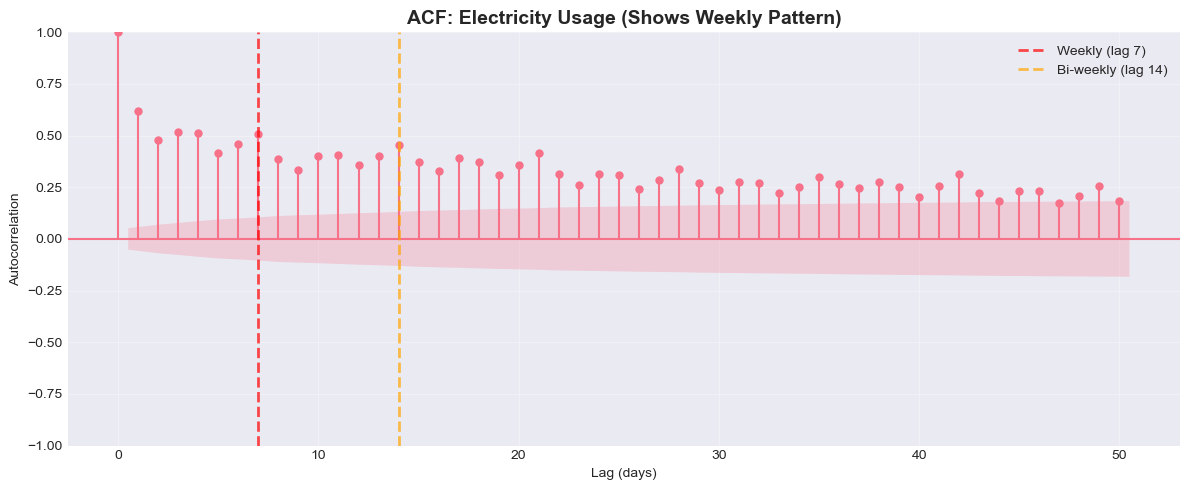

ACF interpretation:
1. Strong autocorrelation at lag 7 (weekly pattern)
2. Autocorrelation at lags 14, 21, etc. (multiples of 7)
3. Slow decay indicates trend


In [27]:
# ACF plot to check for seasonality (zoom on first 50 lags to see weekly pattern)
fig, axes = plt.subplots(1, 1, figsize=(12, 5))

plot_acf(df['usage'].dropna(), lags=50, ax=axes, alpha=0.05)
axes.axvline(x=7, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Weekly (lag 7)')
axes.axvline(x=14, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Bi-weekly (lag 14)')
axes.set_title('ACF: Electricity Usage (Shows Weekly Pattern)', fontsize=14, fontweight='bold')
axes.set_xlabel('Lag (days)')
axes.set_ylabel('Autocorrelation')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ACF interpretation:")
print("1. Strong autocorrelation at lag 7 (weekly pattern)")
print("2. Autocorrelation at lags 14, 21, etc. (multiples of 7)")
print("3. Slow decay indicates trend")

Decomposing time series into components...


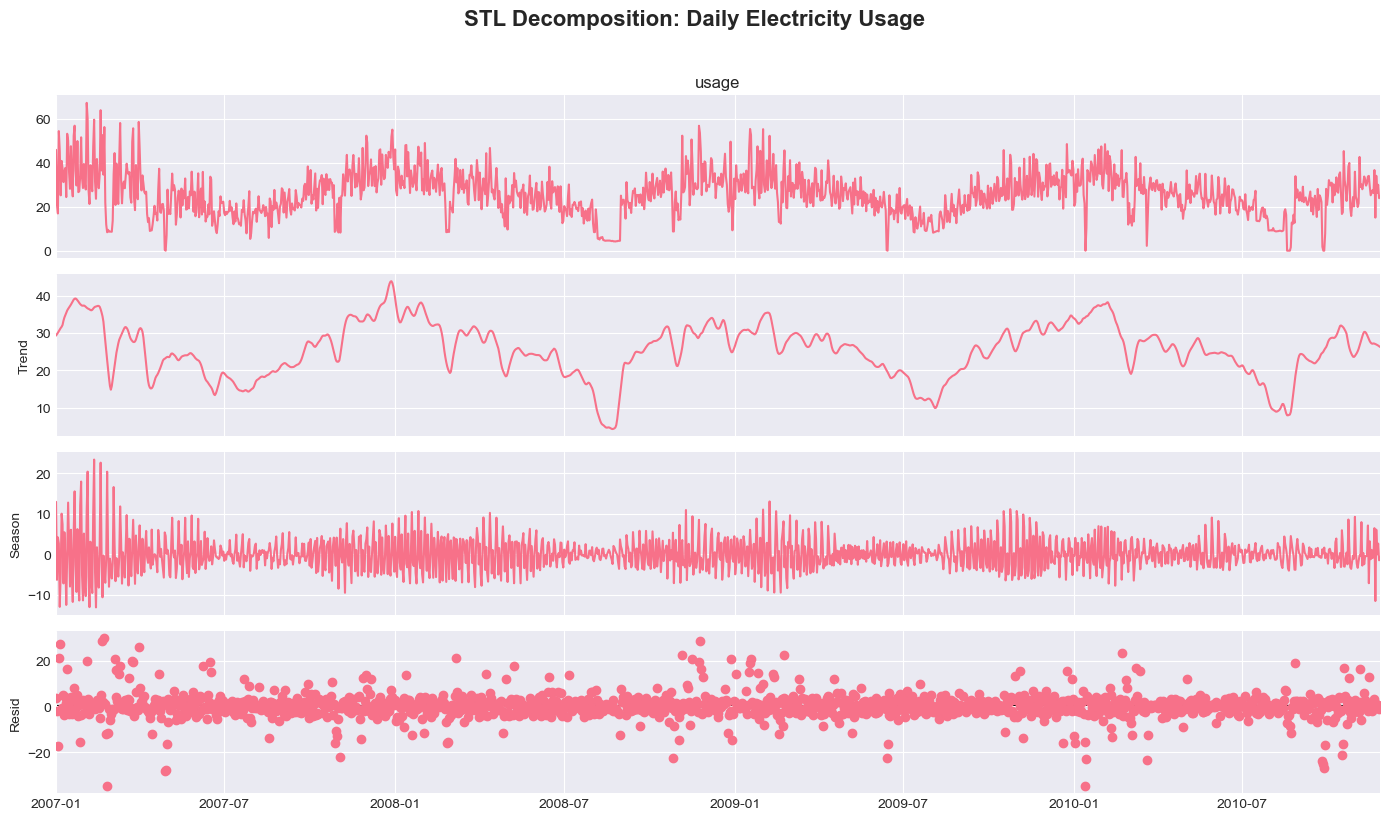

Decomposition insights:
1. Trend: 4.25 to 43.85 kWh (shows overall direction)
2. Weekly seasonality: -13.18 to 23.35 kWh (weekend effect)
3. Remainder std: 5.67 kWh (random variation)


In [28]:
# Quick decomposition to understand components (optional, can skip for brevity)
print("Decomposing time series into components...")

# Use STL for robust decomposition (period=7 for weekly seasonality)
stl = STL(df['usage'], period=7, robust=True)
stl_result = stl.fit()

# Plot decomposition
fig = stl_result.plot()
fig.set_size_inches(14, 8)
plt.suptitle('STL Decomposition: Daily Electricity Usage', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Decomposition insights:")
print(f"1. Trend: {stl_result.trend.min():.2f} to {stl_result.trend.max():.2f} kWh (shows overall direction)")
print(f"2. Weekly seasonality: {stl_result.seasonal.min():.2f} to {stl_result.seasonal.max():.2f} kWh (weekend effect)")
print(f"3. Remainder std: {stl_result.resid.std():.2f} kWh (random variation)")

## Part 3: Prepare Train/Test Split

For forecasting evaluation, we'll split the data into:
- **Training set**: Used to fit the models
- **Test set (holdout)**: Used to evaluate true forecast performance

The split will be determined automatically based on the data:
- For UCI dataset (2007-2010): Use last year for testing
- For synthetic/newer datasets: Use last 6 months for testing

In [29]:
# Split into train and test sets
# Use last 6 months (or ~15% of data) for testing, whichever is appropriate
# For UCI data (2007-2010), use last year for testing
# For synthetic data (2020-2024), use last 6 months for testing

max_date = df.index.max()
if max_date.year <= 2011:
    # UCI dataset: use last year for testing
    test_start = pd.Timestamp(str(max_date.year - 1) + '-01-01')
else:
    # Synthetic data or newer datasets: use last 6 months for testing
    test_start = max_date - pd.Timedelta(days=180)

train_end = test_start - pd.Timedelta(days=1)

train = df.loc[:train_end].copy()
test = df.loc[test_start:].copy()

print(f"Training set: {train.index.min()} to {train.index.max()}")
print(f"  Number of observations: {len(train)}")
print(f"\nTest set: {test.index.min()} to {test.index.max()}")
print(f"  Number of observations: {len(test)}")
print(f"\nTraining set covers {len(train)/len(df)*100:.1f}% of data")
print(f"Test set covers {len(test)/len(df)*100:.1f}% of data")

Training set: 2007-01-01 00:00:00 to 2008-12-31 00:00:00
  Number of observations: 731

Test set: 2009-01-01 00:00:00 to 2010-11-26 00:00:00
  Number of observations: 695

Training set covers 51.3% of data
Test set covers 48.7% of data


## Part 4: Linear Regression for Forecasting

Linear regression can be used for forecasting by:
1. Using time index as a predictor (captures trend)
2. Using dummy variables for day of week (captures weekly seasonality)
3. Using month dummies (captures annual seasonality)

**Model:** $Y_t = \\beta_0 + \\beta_1 t + \\beta_2 \\text{Weekend}_t + \\beta_3 \\text{Month}_t + \\epsilon_t$

In [30]:
# Prepare features for linear regression
# Time index
train['time_index'] = np.arange(len(train))
test['time_index'] = np.arange(len(train), len(train) + len(test))

# Day of week dummies (Monday as baseline)
train_day_dummies = pd.get_dummies(train['day_of_week'], prefix='day', drop_first=True)
test_day_dummies = pd.get_dummies(test['day_of_week'], prefix='day', drop_first=True)

# Ensure both have same columns
all_day_cols = train_day_dummies.columns.union(test_day_dummies.columns)
train_day_dummies = train_day_dummies.reindex(columns=all_day_cols, fill_value=0)
test_day_dummies = test_day_dummies.reindex(columns=all_day_cols, fill_value=0)

# Month dummies (January as baseline)
train_month_dummies = pd.get_dummies(train['month'], prefix='month', drop_first=True)
test_month_dummies = pd.get_dummies(test['month'], prefix='month', drop_first=True)

# Ensure both have same columns
all_month_cols = train_month_dummies.columns.union(test_month_dummies.columns)
train_month_dummies = train_month_dummies.reindex(columns=all_month_cols, fill_value=0)
test_month_dummies = test_month_dummies.reindex(columns=all_month_cols, fill_value=0)

# Combine features
X_train_lr = pd.concat([train[['time_index']], train_day_dummies, train_month_dummies], axis=1)
X_test_lr = pd.concat([test[['time_index']], test_day_dummies, test_month_dummies], axis=1)

y_train = train['usage']
y_test = test['usage']

print(f"Training features shape: {X_train_lr.shape}")
print(f"Test features shape: {X_test_lr.shape}")

Training features shape: (731, 18)
Test features shape: (695, 18)


In [32]:
# Fit linear regression model using statsmodels OLS for detailed summary
# Ensure all features are numeric (convert to float64)
X_train_lr = X_train_lr.astype(float)
X_test_lr = X_test_lr.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Add constant term (intercept)
X_train_ols = sm.add_constant(X_train_lr)
X_test_ols = sm.add_constant(X_test_lr)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Predictions
y_train_pred_lr = ols_model.predict(X_train_ols)
y_test_pred_lr = ols_model.predict(X_test_ols)

# Evaluate performance
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))

print("Linear Regression Results:")
print("=" * 60)

# Display full OLS model summary
print("\nFull Model Summary:")
print("=" * 60)
print(ols_model.summary())

print("\n" + "=" * 60)
print("Model Performance Metrics:")
print("=" * 60)
print(f"Training MAE: {train_mae_lr:.2f} kWh")
print(f"Training RMSE: {train_rmse_lr:.2f} kWh")
print(f"\nTest MAE: {test_mae_lr:.2f} kWh")
print(f"Test RMSE: {test_rmse_lr:.2f} kWh")
print(f"\nR-squared: {ols_model.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model.rsquared_adj:.4f}")

# Print key coefficients with interpretation
print(f"\n" + "=" * 60)
print("Key Coefficient Interpretation:")
print("=" * 60)
print(f"Intercept: {ols_model.params['const']:.4f} kWh")
print(f"  Interpretation: Baseline daily electricity usage (on Monday in January)")
print(f"\nTime trend: {ols_model.params['time_index']:.6f} kWh per day")
pvalue_trend = ols_model.pvalues['time_index']
print(f"  P-value: {pvalue_trend:.4f} {'***' if pvalue_trend < 0.001 else '**' if pvalue_trend < 0.01 else '*' if pvalue_trend < 0.05 else '(not significant)'}")
print(f"  Interpretation: Change in daily usage per day")

# Note: kWh = kilowatt-hours, the standard unit for household electricity usage
print(f"\nNote: kWh = kilowatt-hours (1 kWh = 1000 Wh = typical unit for household electricity)")
print(f"      For reference: 1 kWh ≈ $0.10-0.15 in the U.S., or running a 100W light bulb for 10 hours")

Linear Regression Results:

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  usage   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     31.70
Date:                Mon, 19 Jan 2026   Prob (F-statistic):           1.11e-78
Time:                        17:11:16   Log-Likelihood:                -2570.4
No. Observations:                 731   AIC:                             5179.
Df Residuals:                     712   BIC:                             5266.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

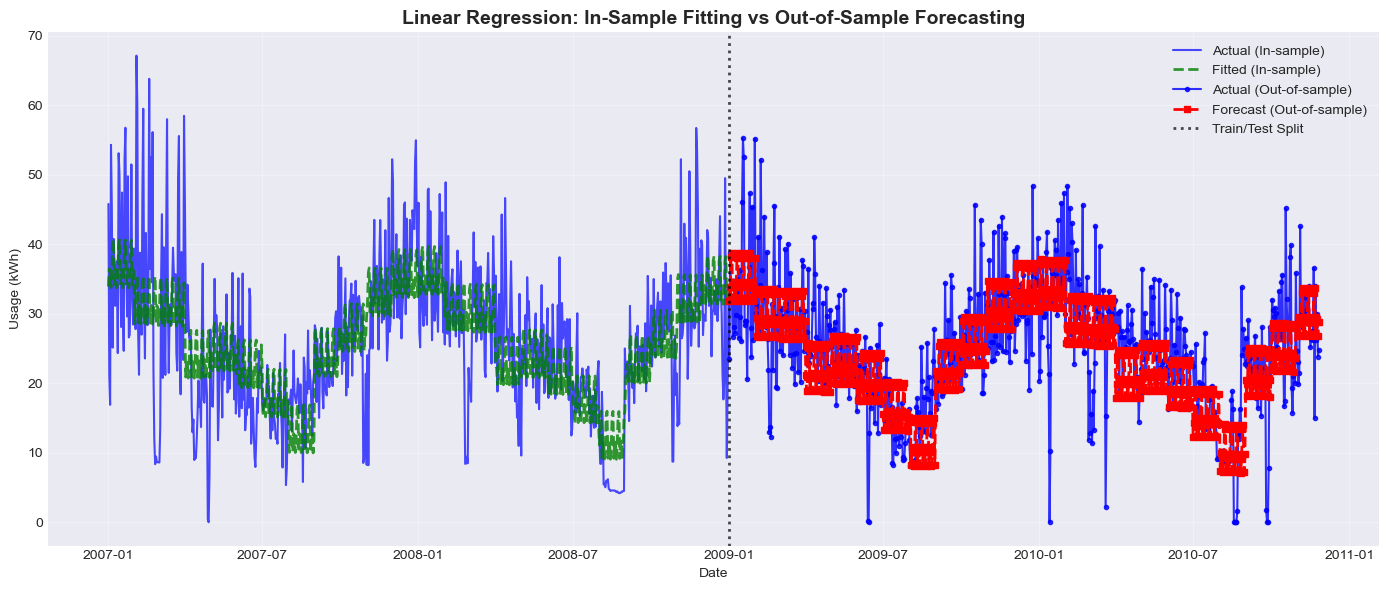

Linear Regression Observations:
1. Captures overall trend well
2. Captures weekly and monthly patterns
3. May miss some short-term dynamics


In [33]:
# Visualize linear regression: Combined in-sample fitting and out-of-sample forecasting
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# In-sample fitting
axes.plot(train.index, train['usage'], label='Actual (In-sample)', linewidth=1.5, alpha=0.7, color='blue')
axes.plot(train.index, y_train_pred_lr, label='Fitted (In-sample)', linewidth=2, color='green', linestyle='--', alpha=0.8)

# Out-of-sample forecasting
axes.plot(test.index, test['usage'], label='Actual (Out-of-sample)', linewidth=1.5, color='blue', marker='o', markersize=3, alpha=0.8)
axes.plot(test.index, y_test_pred_lr, label='Forecast (Out-of-sample)', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)

# Vertical line to separate in-sample and out-of-sample
axes.axvline(x=pd.to_datetime(test_start), color='black', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')

axes.set_title('Linear Regression: In-Sample Fitting vs Out-of-Sample Forecasting', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Usage (kWh)')
axes.legend(loc='best')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Linear Regression Observations:")
print("1. Captures overall trend well")
print("2. Captures weekly and monthly patterns")
print("3. May miss some short-term dynamics")

## Part 4b: Expanding Window Forecast Evaluation by Horizon

Now let's evaluate forecast accuracy by **forecast horizon** (how far ahead we're forecasting) using an **expanding window** approach:

- **Expanding window**: Start with initial training set, then gradually expand it
- **Forecast horizons**: 1-week (7 days) and 1-month (30 days) ahead
- This shows how forecast accuracy changes as we forecast further into the future

Expanding Window Forecast Evaluation by Horizon
Initial training set: 1140 observations
Remaining data for expanding window: 286 observations

Starting expanding window evaluation...
✓ Completed 10 expanding window evaluations

Forecast Accuracy by Horizon (Expanding Window):

1-WEEK (7 days ahead):
  MAE: 12.368 kWh
  RMSE: 14.644 kWh
  MAPE: inf%
  Number of forecasts: 10

1-MONTH (30 days ahead):
  MAE: 9.392 kWh
  RMSE: 11.402 kWh
  MAPE: 50.79%
  Number of forecasts: 9


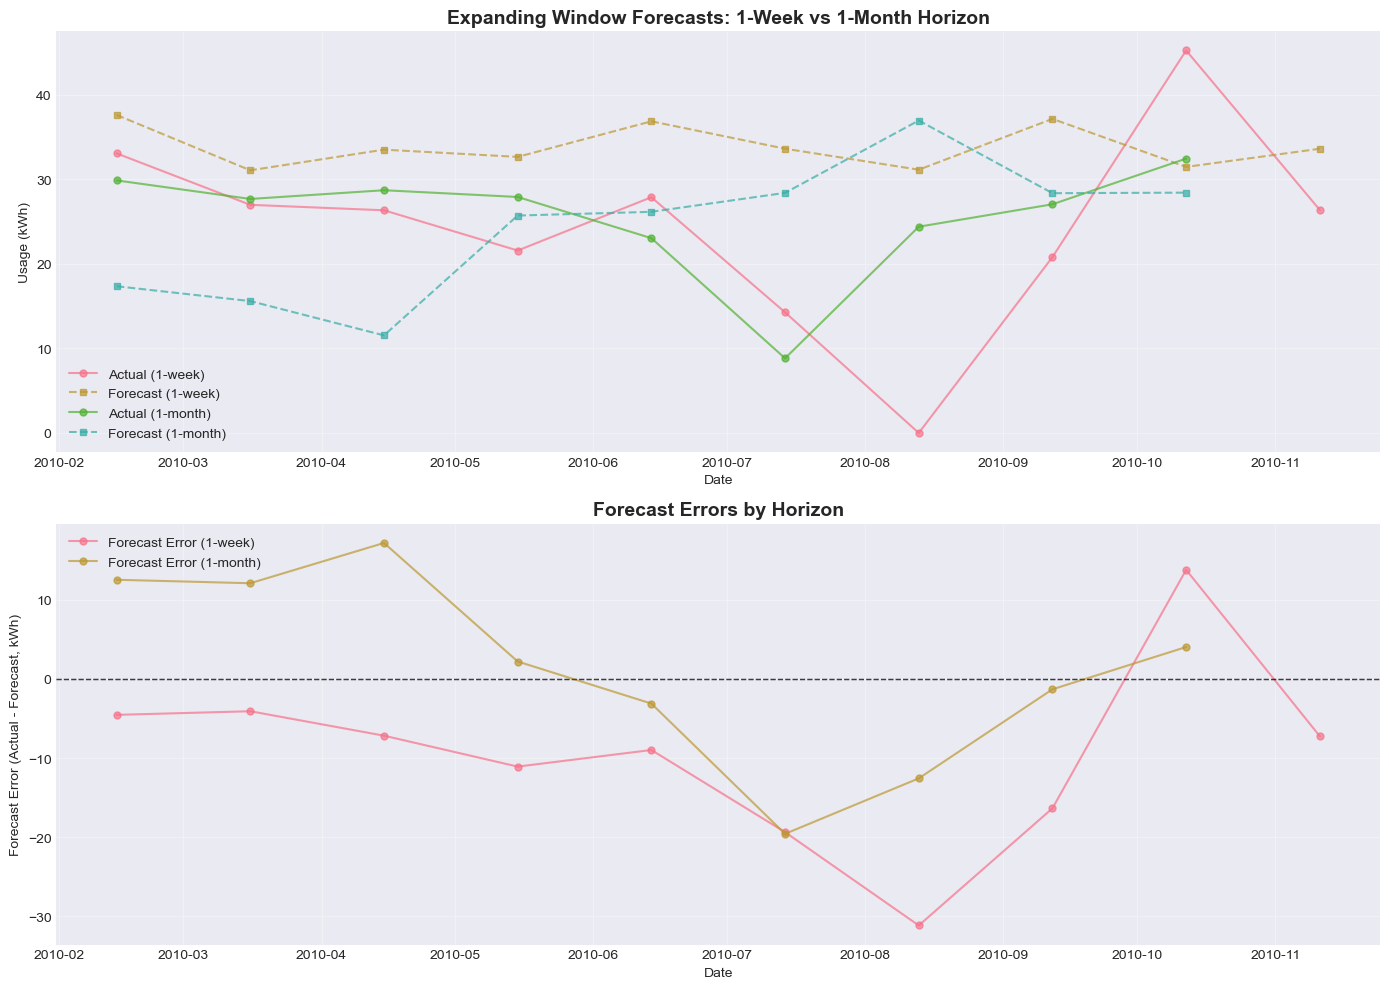


Key Observations:
1. Forecast accuracy generally decreases as forecast horizon increases
2. 1-week forecasts are typically more accurate than 1-month forecasts
3. Expanding window allows model to incorporate new data over time


In [ ]:
# Expanding window forecast evaluation by horizon
# We'll use Linear Regression for this demonstration

print("Expanding Window Forecast Evaluation by Horizon")
print("=" * 60)

# Define forecast horizons (in days)
horizons = {
    '1-week': 7,
    '1-month': 30
}

# Initialize storage for results
forecast_results = {horizon: {'dates': [], 'actual': [], 'forecast': [], 'error': []} 
                    for horizon in horizons.keys()}

# Initial training set: use first 80% of data for initial training
initial_train_size = int(len(df) * 0.8)
initial_train = df.iloc[:initial_train_size].copy()
remaining_data = df.iloc[initial_train_size:].copy()

print(f"Initial training set: {len(initial_train)} observations")
print(f"Remaining data for expanding window: {len(remaining_data)} observations")
print(f"\nStarting expanding window evaluation...")

# Expanding window: start from initial_train_size, expand by 30 days at a time
step_size = 30  # Expand training set by 30 days each iteration

for end_idx in range(initial_train_size, len(df), step_size):
    # Current training set (expanding window)
    train_expanding = df.iloc[:end_idx].copy()
    
    # Get test period (next 30 days, or until end of data)
    test_start_idx = end_idx
    test_end_idx = min(end_idx + 30, len(df))
    
    if test_end_idx - test_start_idx < 7:  # Need at least 7 days for 1-week forecast
        break
    
    test_expanding = df.iloc[test_start_idx:test_end_idx].copy()
    test_date = test_expanding.index[0]
    
    # Prepare features for current expanding window
    train_expanding['time_index'] = np.arange(len(train_expanding))
    
    # Day of week dummies
    train_day_dummies = pd.get_dummies(train_expanding['day_of_week'], prefix='day', drop_first=True)
    
    # Month dummies
    train_month_dummies = pd.get_dummies(train_expanding['month'], prefix='month', drop_first=True)
    
    # Combine features
    X_train_exp = pd.concat([train_expanding[['time_index']], train_day_dummies, train_month_dummies], axis=1)
    y_train_exp = train_expanding['usage']
    
    # Ensure all features are numeric (convert to float64)
    X_train_exp = X_train_exp.astype(float)
    y_train_exp = y_train_exp.astype(float)
    
    # Fit model
    X_train_exp_ols = sm.add_constant(X_train_exp)
    ols_expanding = sm.OLS(y_train_exp, X_train_exp_ols).fit()
    
    # Make forecasts for each horizon
    for horizon_name, horizon_days in horizons.items():
        if len(test_expanding) >= horizon_days:
            # Forecast for specific horizon
            test_horizon = test_expanding.iloc[:horizon_days].copy()
            
            # Prepare test features
            test_horizon['time_index'] = np.arange(len(train_expanding), len(train_expanding) + len(test_horizon))
            test_day_dummies = pd.get_dummies(test_horizon['day_of_week'], prefix='day', drop_first=True)
            test_month_dummies = pd.get_dummies(test_horizon['month'], prefix='month', drop_first=True)
            
            # Ensure same columns as training
            all_day_cols = train_day_dummies.columns.union(test_day_dummies.columns)
            test_day_dummies = test_day_dummies.reindex(columns=all_day_cols, fill_value=0)
            
            all_month_cols = train_month_dummies.columns.union(test_month_dummies.columns)
            test_month_dummies = test_month_dummies.reindex(columns=all_month_cols, fill_value=0)
            
            X_test_horizon = pd.concat([test_horizon[['time_index']], test_day_dummies, test_month_dummies], axis=1)
            
            # Ensure all features are numeric (convert to float64)
            X_test_horizon = X_test_horizon.astype(float)
            
            X_test_horizon_ols = sm.add_constant(X_test_horizon)
            
            # Forecast
            forecast_horizon = ols_expanding.predict(X_test_horizon_ols)
            actual_horizon = test_horizon['usage'].values
            
            # Store results
            # Check if values are valid (not NaN)
            actual_val = actual_horizon[-1]
            forecast_val = forecast_horizon.iloc[-1]
            
            if not (np.isnan(actual_val) or np.isnan(forecast_val)):
                forecast_results[horizon_name]['dates'].append(test_date)
                forecast_results[horizon_name]['actual'].append(actual_val)
                forecast_results[horizon_name]['forecast'].append(forecast_val)
                forecast_results[horizon_name]['error'].append(actual_val - forecast_val)

print(f"✓ Completed {len(forecast_results['1-week']['dates'])} expanding window evaluations")

# Calculate accuracy metrics by horizon
print("\n" + "=" * 60)
print("Forecast Accuracy by Horizon (Expanding Window):")
print("=" * 60)

for horizon_name in horizons.keys():
    actual = np.array(forecast_results[horizon_name]['actual'])
    forecast = np.array(forecast_results[horizon_name]['forecast'])
    
    # Data should be clean already (zeros removed at beginning), but double-check
    valid_mask = ~(np.isnan(actual) | np.isnan(forecast) | (actual <= 0))
    actual_valid = actual[valid_mask]
    forecast_valid = forecast[valid_mask]
    
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    # MAPE: Calculate on all valid forecasts (should be all if data was cleaned properly)
    if len(actual_valid) > 0:
        mape = np.mean(np.abs((actual_valid - forecast_valid) / actual_valid)) * 100
        invalid_count = len(actual) - len(actual_valid)
    else:
        mape = np.nan
        invalid_count = len(actual)
    
    print(f"\n{horizon_name.upper()} ({horizons[horizon_name]} days ahead):")
    print(f"  MAE: {mae:.3f} kWh")
    print(f"  RMSE: {rmse:.3f} kWh")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Number of forecasts: {len(actual)}")
    if invalid_count > 0:
        print(f"  ⚠️  Warning: {invalid_count} forecast(s) had invalid values (excluded from MAPE)")

# Visualize forecast accuracy by horizon
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Forecasts vs Actual by horizon
for i, (horizon_name, horizon_days) in enumerate(horizons.items()):
    dates = forecast_results[horizon_name]['dates']
    actual = np.array(forecast_results[horizon_name]['actual'])
    forecast = np.array(forecast_results[horizon_name]['forecast'])
    
    axes[0].plot(dates, actual, 'o-', label=f'Actual ({horizon_name})', 
                linewidth=1.5, markersize=5, alpha=0.7)
    axes[0].plot(dates, forecast, 's--', label=f'Forecast ({horizon_name})', 
                linewidth=1.5, markersize=5, alpha=0.7)

axes[0].set_title('Expanding Window Forecasts: 1-Week vs 1-Month Horizon', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Usage (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Forecast errors by horizon
for i, (horizon_name, horizon_days) in enumerate(horizons.items()):
    dates = forecast_results[horizon_name]['dates']
    errors = np.array(forecast_results[horizon_name]['error'])
    
    axes[1].plot(dates, errors, 'o-', label=f'Forecast Error ({horizon_name})', 
                linewidth=1.5, markersize=5, alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

axes[1].set_title('Forecast Errors by Horizon', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Forecast Error (Actual - Forecast, kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("1. Forecast accuracy generally decreases as forecast horizon increases")
print("2. 1-week forecasts are typically more accurate than 1-month forecasts")
print("3. Expanding window allows model to incorporate new data over time")

## Part 5: Simple Exponential Smoothing (SES)

**Simple Exponential Smoothing** is a simple forecasting method that:
- Uses a weighted average of past observations
- Gives more weight to recent observations
- Assumes no trend or seasonality

**Model:** $\\hat{y}_{t+1} = \\alpha y_t + (1-\\alpha) \\hat{y}_t$

where $\\alpha$ is the smoothing parameter ($0 < \\alpha < 1$)

In [35]:
# Fit Simple Exponential Smoothing
# SES assumes no trend and no seasonality
print("Fitting Simple Exponential Smoothing (SES)...")

# Fit SES model
ses_model = SimpleExpSmoothing(train['usage'])
ses_fitted = ses_model.fit(optimized=True)  # Let statsmodels optimize alpha

# Forecast
y_train_pred_ses = ses_fitted.fittedvalues
y_test_pred_ses = ses_fitted.forecast(len(test))

# Evaluate performance
train_mae_ses = mean_absolute_error(y_train, y_train_pred_ses)
train_rmse_ses = np.sqrt(mean_squared_error(y_train, y_train_pred_ses))
test_mae_ses = mean_absolute_error(y_test, y_test_pred_ses)
test_rmse_ses = np.sqrt(mean_squared_error(y_test, y_test_pred_ses))

print("Simple Exponential Smoothing Results:")
print("=" * 60)
print(f"Smoothing parameter (alpha): {ses_fitted.params['smoothing_level']:.4f}")
print(f"Training MAE: {train_mae_ses:.2f} kWh")
print(f"Training RMSE: {train_rmse_ses:.2f} kWh")
print(f"\nTest MAE: {test_mae_ses:.2f} kWh")
print(f"Test RMSE: {test_rmse_ses:.2f} kWh")

print(f"\nInterpretation:")
print(f"  Alpha = {ses_fitted.params['smoothing_level']:.4f} means we give {ses_fitted.params['smoothing_level']*100:.1f}% weight to the most recent observation")
print(f"  and {(1-ses_fitted.params['smoothing_level'])*100:.1f}% weight to the previous forecast")

Fitting Simple Exponential Smoothing (SES)...
Simple Exponential Smoothing Results:
Smoothing parameter (alpha): 0.2677
Training MAE: 6.12 kWh
Training RMSE: 8.25 kWh

Test MAE: 6.89 kWh
Test RMSE: 9.00 kWh

Interpretation:
  Alpha = 0.2677 means we give 26.8% weight to the most recent observation
  and 73.2% weight to the previous forecast


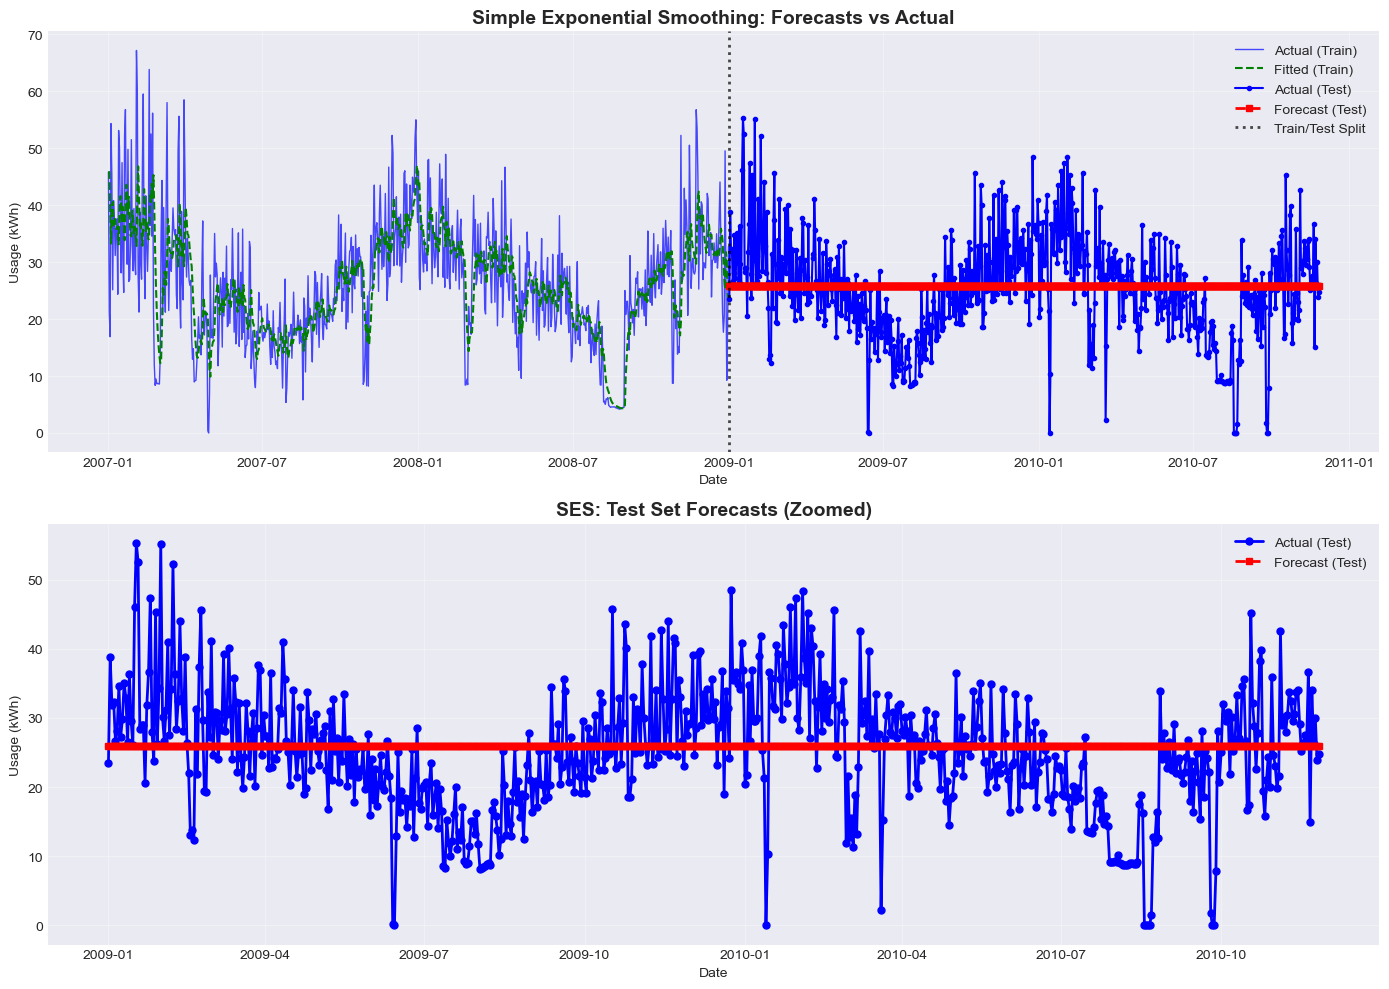

SES Observations:
1. SES assumes no trend, so it lags behind when there's an upward trend
2. SES cannot capture seasonality (weekly patterns)
3. Good for series with no trend/seasonality, but not ideal here


In [36]:
# Visualize SES forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Training and test predictions
axes[0].plot(train.index, train['usage'], label='Actual (Train)', linewidth=1, alpha=0.7, color='blue')
axes[0].plot(train.index, y_train_pred_ses, label='Fitted (Train)', linewidth=1.5, color='green', linestyle='--')
axes[0].plot(test.index, test['usage'], label='Actual (Test)', linewidth=1.5, color='blue', marker='o', markersize=3)
axes[0].plot(test.index, y_test_pred_ses, label='Forecast (Test)', linewidth=2, color='red', linestyle='--', marker='s', markersize=4)
axes[0].axvline(x=pd.to_datetime(test_start), color='black', linestyle=':', linewidth=2, alpha=0.7, label='Train/Test Split')
axes[0].set_title('Simple Exponential Smoothing: Forecasts vs Actual', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Usage (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom on test set
axes[1].plot(test.index, test['usage'], label='Actual (Test)', linewidth=2, marker='o', markersize=5, color='blue')
axes[1].plot(test.index, y_test_pred_ses, label='Forecast (Test)', linewidth=2, marker='s', markersize=5, color='red', linestyle='--')
axes[1].set_title('SES: Test Set Forecasts (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Usage (kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("SES Observations:")
print("1. SES assumes no trend, so it lags behind when there's an upward trend")
print("2. SES cannot capture seasonality (weekly patterns)")
print("3. Good for series with no trend/seasonality, but not ideal here")

## Part 6: ETS Models (Error, Trend, Seasonal)

**ETS models** extend exponential smoothing to handle:
- **Error (E)**: Additive (A) or Multiplicative (M)
- **Trend (T)**: None (N), Additive (A), or Multiplicative (M)
- **Seasonal (S)**: None (N), Additive (A), or Multiplicative (M)

We'll try several ETS models:
1. **ETS(A,N,N)**: Additive error, No trend, No seasonality (same as SES)
2. **ETS(A,A,N)**: Additive error, Additive trend, No seasonality
3. **ETS(A,A,A)**: Additive error, Additive trend, Additive seasonality (weekly)

In [ ]:
# ETS Model 1: ETS(A,N,N) - Simple Exponential Smoothing
print("Fitting ETS Models...")
print("=" * 60)

# ETS(A,N,N) - Same as SES
ets_ann = ExponentialSmoothing(train['usage'], trend=None, seasonal=None)
ets_ann_fitted = ets_ann.fit()

print("\nETS(A,N,N) - No trend, No seasonality:")
print("=" * 60)
print(ets_ann_fitted.summary())

y_test_pred_ann = ets_ann_fitted.forecast(len(test))
test_mae_ann = mean_absolute_error(y_test, y_test_pred_ann)
test_rmse_ann = np.sqrt(mean_squared_error(y_test, y_test_pred_ann))

print(f"\nPerformance Metrics:")
print(f"  Test MAE: {test_mae_ann:.2f} kWh")
print(f"  Test RMSE: {test_rmse_ann:.2f} kWh")
print(f"  AIC: {ets_ann_fitted.aic:.2f}")
print(f"  BIC: {ets_ann_fitted.bic:.2f}")

Fitting ETS Models...
ETS(A,N,N) - No trend, No seasonality:
  Test MAE: 6.90 kWh
  Test RMSE: 9.00 kWh
  AIC: 3084.90


In [ ]:
# ETS Model 2: ETS(A,A,N) - Additive trend, No seasonality
ets_aan = ExponentialSmoothing(train['usage'], trend='add', seasonal=None)
ets_aan_fitted = ets_aan.fit()

print("\nETS(A,A,N) - Additive trend, No seasonality:")
print("=" * 60)
print(ets_aan_fitted.summary())

y_test_pred_aan = ets_aan_fitted.forecast(len(test))
test_mae_aan = mean_absolute_error(y_test, y_test_pred_aan)
test_rmse_aan = np.sqrt(mean_squared_error(y_test, y_test_pred_aan))

print(f"\nPerformance Metrics:")
print(f"  Test MAE: {test_mae_aan:.2f} kWh")
print(f"  Test RMSE: {test_rmse_aan:.2f} kWh")
print(f"  AIC: {ets_aan_fitted.aic:.2f}")
print(f"  BIC: {ets_aan_fitted.bic:.2f}")

ETS(A,A,N) - Additive trend, No seasonality:
  Test MAE: 7.70 kWh
  Test RMSE: 9.71 kWh
  AIC: 3088.88


In [ ]:
# ETS Model 3: ETS(A,A,A) - Additive trend, Additive seasonality (weekly)
ets_aaa = ExponentialSmoothing(train['usage'], trend='add', seasonal='add', seasonal_periods=7)
ets_aaa_fitted = ets_aaa.fit()

print("\nETS(A,A,A) - Additive trend, Additive weekly seasonality:")
print("=" * 60)
print(ets_aaa_fitted.summary())

y_test_pred_aaa = ets_aaa_fitted.forecast(len(test))
test_mae_aaa = mean_absolute_error(y_test, y_test_pred_aaa)
test_rmse_aaa = np.sqrt(mean_squared_error(y_test, y_test_pred_aaa))

print(f"\nPerformance Metrics:")
print(f"  Test MAE: {test_mae_aaa:.2f} kWh")
print(f"  Test RMSE: {test_rmse_aaa:.2f} kWh")
print(f"  AIC: {ets_aaa_fitted.aic:.2f}")
print(f"  BIC: {ets_aaa_fitted.bic:.2f}")

ETS(A,A,A) - Additive trend, Additive weekly seasonality:
  Test MAE: 8.55 kWh
  Test RMSE: 10.51 kWh
  AIC: 2981.18


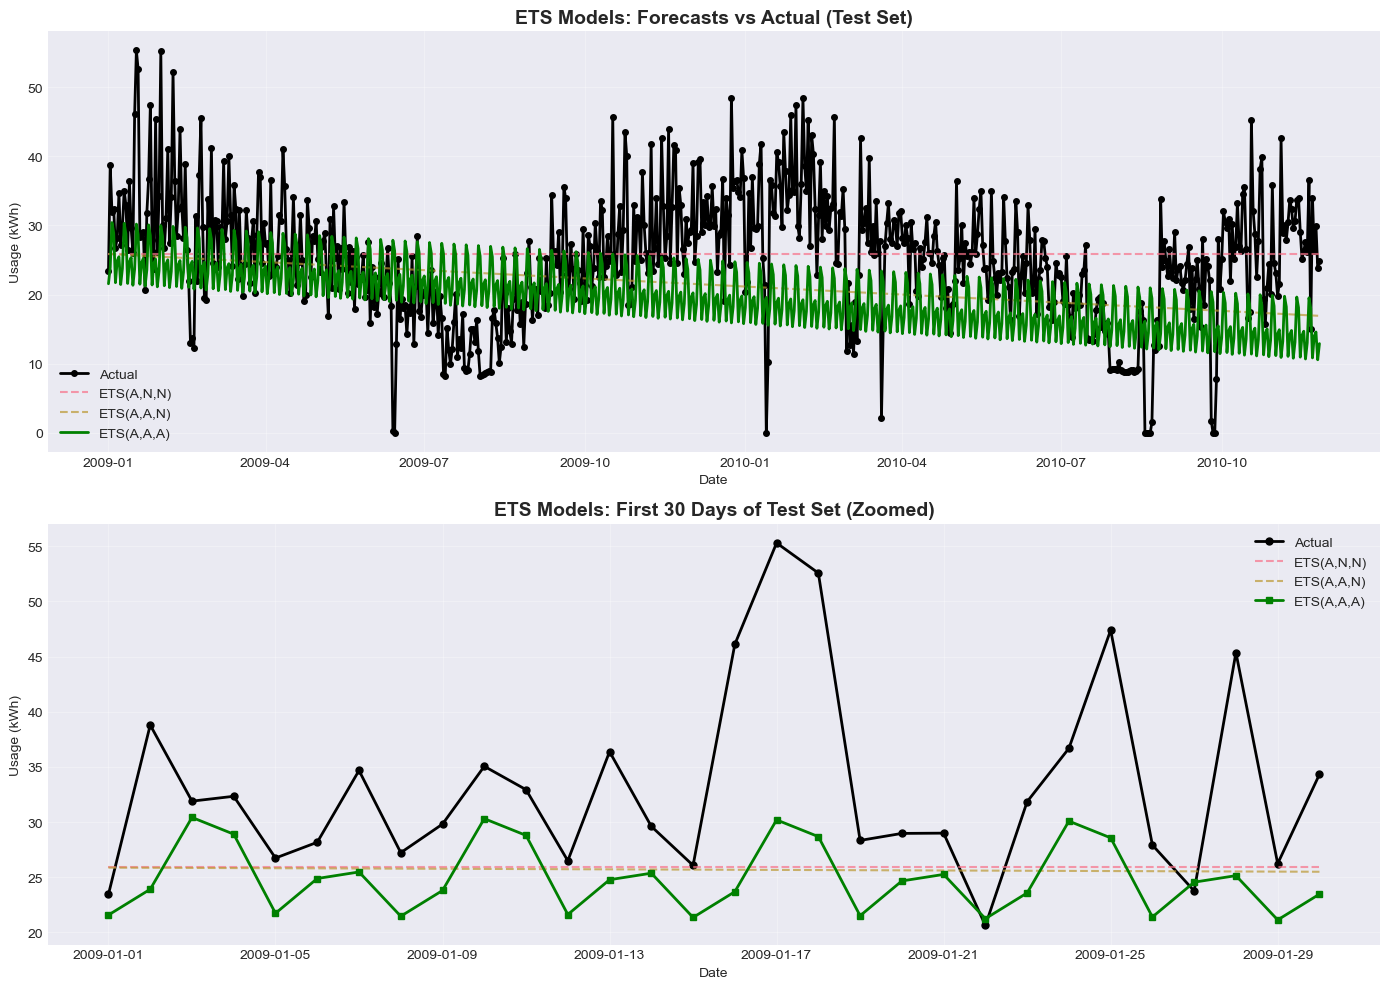

ETS Model Observations:
1. ETS(A,A,A) captures weekly seasonality, improving forecasts
2. ETS(A,A,N) captures trend but misses weekly patterns
3. ETS(A,N,N) performs worst (no trend, no seasonality)


In [40]:
# Visualize ETS forecasts
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: All ETS models on test set
axes[0].plot(test.index, test['usage'], label='Actual', linewidth=2, marker='o', markersize=4, color='black')
axes[0].plot(test.index, y_test_pred_ann, label='ETS(A,N,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[0].plot(test.index, y_test_pred_aan, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[0].plot(test.index, y_test_pred_aaa, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='green')
axes[0].set_title('ETS Models: Forecasts vs Actual (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Usage (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Zoom on first month of test set (or first 30 days)
if len(test) >= 30:
    test_first_period = test.iloc[:30]
else:
    test_first_period = test  # Use all test data if less than 30 days

idx_first_period = [i for i in range(len(test_first_period))]
y_test_pred_ann_first = y_test_pred_ann[idx_first_period]
y_test_pred_aan_first = y_test_pred_aan[idx_first_period]
y_test_pred_aaa_first = y_test_pred_aaa[idx_first_period]

axes[1].plot(test_first_period.index, test_first_period['usage'], label='Actual', linewidth=2, marker='o', markersize=5, color='black')
axes[1].plot(test_first_period.index, y_test_pred_ann_first, label='ETS(A,N,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[1].plot(test_first_period.index, y_test_pred_aan_first, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.7)
axes[1].plot(test_first_period.index, y_test_pred_aaa_first, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='green', marker='s', markersize=4)
axes[1].set_title(f'ETS Models: First {len(test_first_period)} Days of Test Set (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Usage (kWh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ETS Model Observations:")
print("1. ETS(A,A,A) captures weekly seasonality, improving forecasts")
print("2. ETS(A,A,N) captures trend but misses weekly patterns")
print("3. ETS(A,N,N) performs worst (no trend, no seasonality)")

## Part 7: Model Comparison

Let's compare all models on the test set.

In [41]:
# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'SES / ETS(A,N,N)', 'ETS(A,A,N)', 'ETS(A,A,A)'],
    'Test MAE': [test_mae_lr, test_mae_ann, test_mae_aan, test_mae_aaa],
    'Test RMSE': [test_rmse_lr, test_rmse_ann, test_rmse_aan, test_rmse_aaa]
})

comparison = comparison.sort_values('Test MAE')
comparison['Rank'] = range(1, len(comparison) + 1)
comparison = comparison[['Rank', 'Model', 'Test MAE', 'Test RMSE']]

print("Model Comparison (Sorted by Test MAE):")
print("=" * 60)
print(comparison.to_string(index=False))

print(f"\n\nBest Model: {comparison.iloc[0]['Model']}")
print(f"  Test MAE: {comparison.iloc[0]['Test MAE']:.2f} kWh")
print(f"  Test RMSE: {comparison.iloc[0]['Test RMSE']:.2f} kWh")

Model Comparison (Sorted by Test MAE):
 Rank             Model  Test MAE  Test RMSE
    1 Linear Regression  5.222715   7.015890
    2  SES / ETS(A,N,N)  6.896927   9.004980
    3        ETS(A,A,N)  7.702100   9.706175
    4        ETS(A,A,A)  8.550829  10.505215


Best Model: Linear Regression
  Test MAE: 5.22 kWh
  Test RMSE: 7.02 kWh


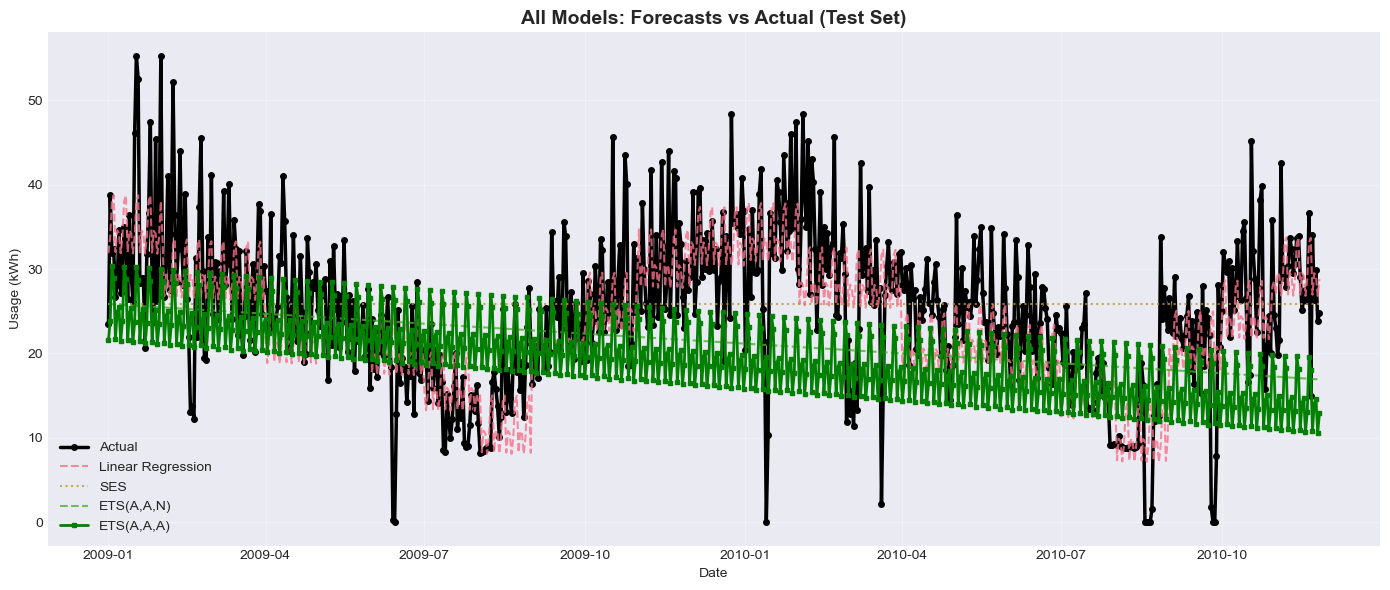

In [42]:
# Visual comparison of all models
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

axes.plot(test.index, test['usage'], label='Actual', linewidth=2.5, marker='o', markersize=4, color='black')
axes.plot(test.index, y_test_pred_lr, label='Linear Regression', linewidth=1.5, linestyle='--', alpha=0.8)
axes.plot(test.index, y_test_pred_ses, label='SES', linewidth=1.5, linestyle=':', alpha=0.8)
axes.plot(test.index, y_test_pred_aan, label='ETS(A,A,N)', linewidth=1.5, linestyle='--', alpha=0.8)
axes.plot(test.index, y_test_pred_aaa, label='ETS(A,A,A)', linewidth=2, linestyle='-', color='green', marker='s', markersize=3)

axes.set_title('All Models: Forecasts vs Actual (Test Set)', fontsize=14, fontweight='bold')
axes.set_xlabel('Date')
axes.set_ylabel('Usage (kWh)')
axes.legend(loc='best')
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary and Key Takeaways

### What We Learned:

1. **Linear Regression for Forecasting:**
   - Can capture trend using time index
   - Can capture seasonality using dummy variables
   - Simple and interpretable
   - Good baseline method

2. **Simple Exponential Smoothing (SES):**
   - Simple weighted average of past observations
   - Assumes no trend or seasonality
   - Good for stable series without patterns
   - Poor for series with trend/seasonality

3. **ETS Models:**
   - Flexible framework for trend and seasonality
   - Can handle additive or multiplicative components
   - ETS(A,A,A) performs well when seasonality is present
   - AIC can help choose between models

### When to Use Each Model:

| Model | Best For | Limitations |
|-------|----------|-------------|
| Linear Regression | Series with deterministic trend/seasonality | Assumes linear relationships |
| SES | Stable series, no trend/seasonality | Cannot handle trends or seasonality |
| ETS(A,A,N) | Series with trend, no seasonality | Misses seasonal patterns |
| ETS(A,A,A) | Series with trend AND seasonality | More complex, requires seasonal period |

### Next Steps:
- **ARIMA models** (Lesson 4): For modeling autocorrelation in the remainder
- **Exogenous variables**: Add weather, holidays, etc. to improve forecasts
- **Ensemble methods**: Combine multiple models for better accuracy

## References

- ECON 5140: Applied Econometrics, Lesson 3 - Forecasting Methods
- Statsmodels documentation: https://www.statsmodels.org/
- Hyndman, R. J., & Athanasopoulos, G. (2021). *Forecasting: principles and practice* (3rd ed.). Available at https://otexts.com/fpp3/
- **UCI Individual Household Electric Power Consumption Dataset**: Hebrail, G. & Berard, A. (2012). Individual household electric power consumption Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
- EIA Electricity Data: https://www.eia.gov/electricity/data.php
- Scikit-learn documentation: https://scikit-learn.org/